# PSYCH253 project: decoding emotion and emotion regulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
from nilearn import plotting
from nilearn.image import mean_img
from nilearn import image
from nilearn.input_data import NiftiMasker


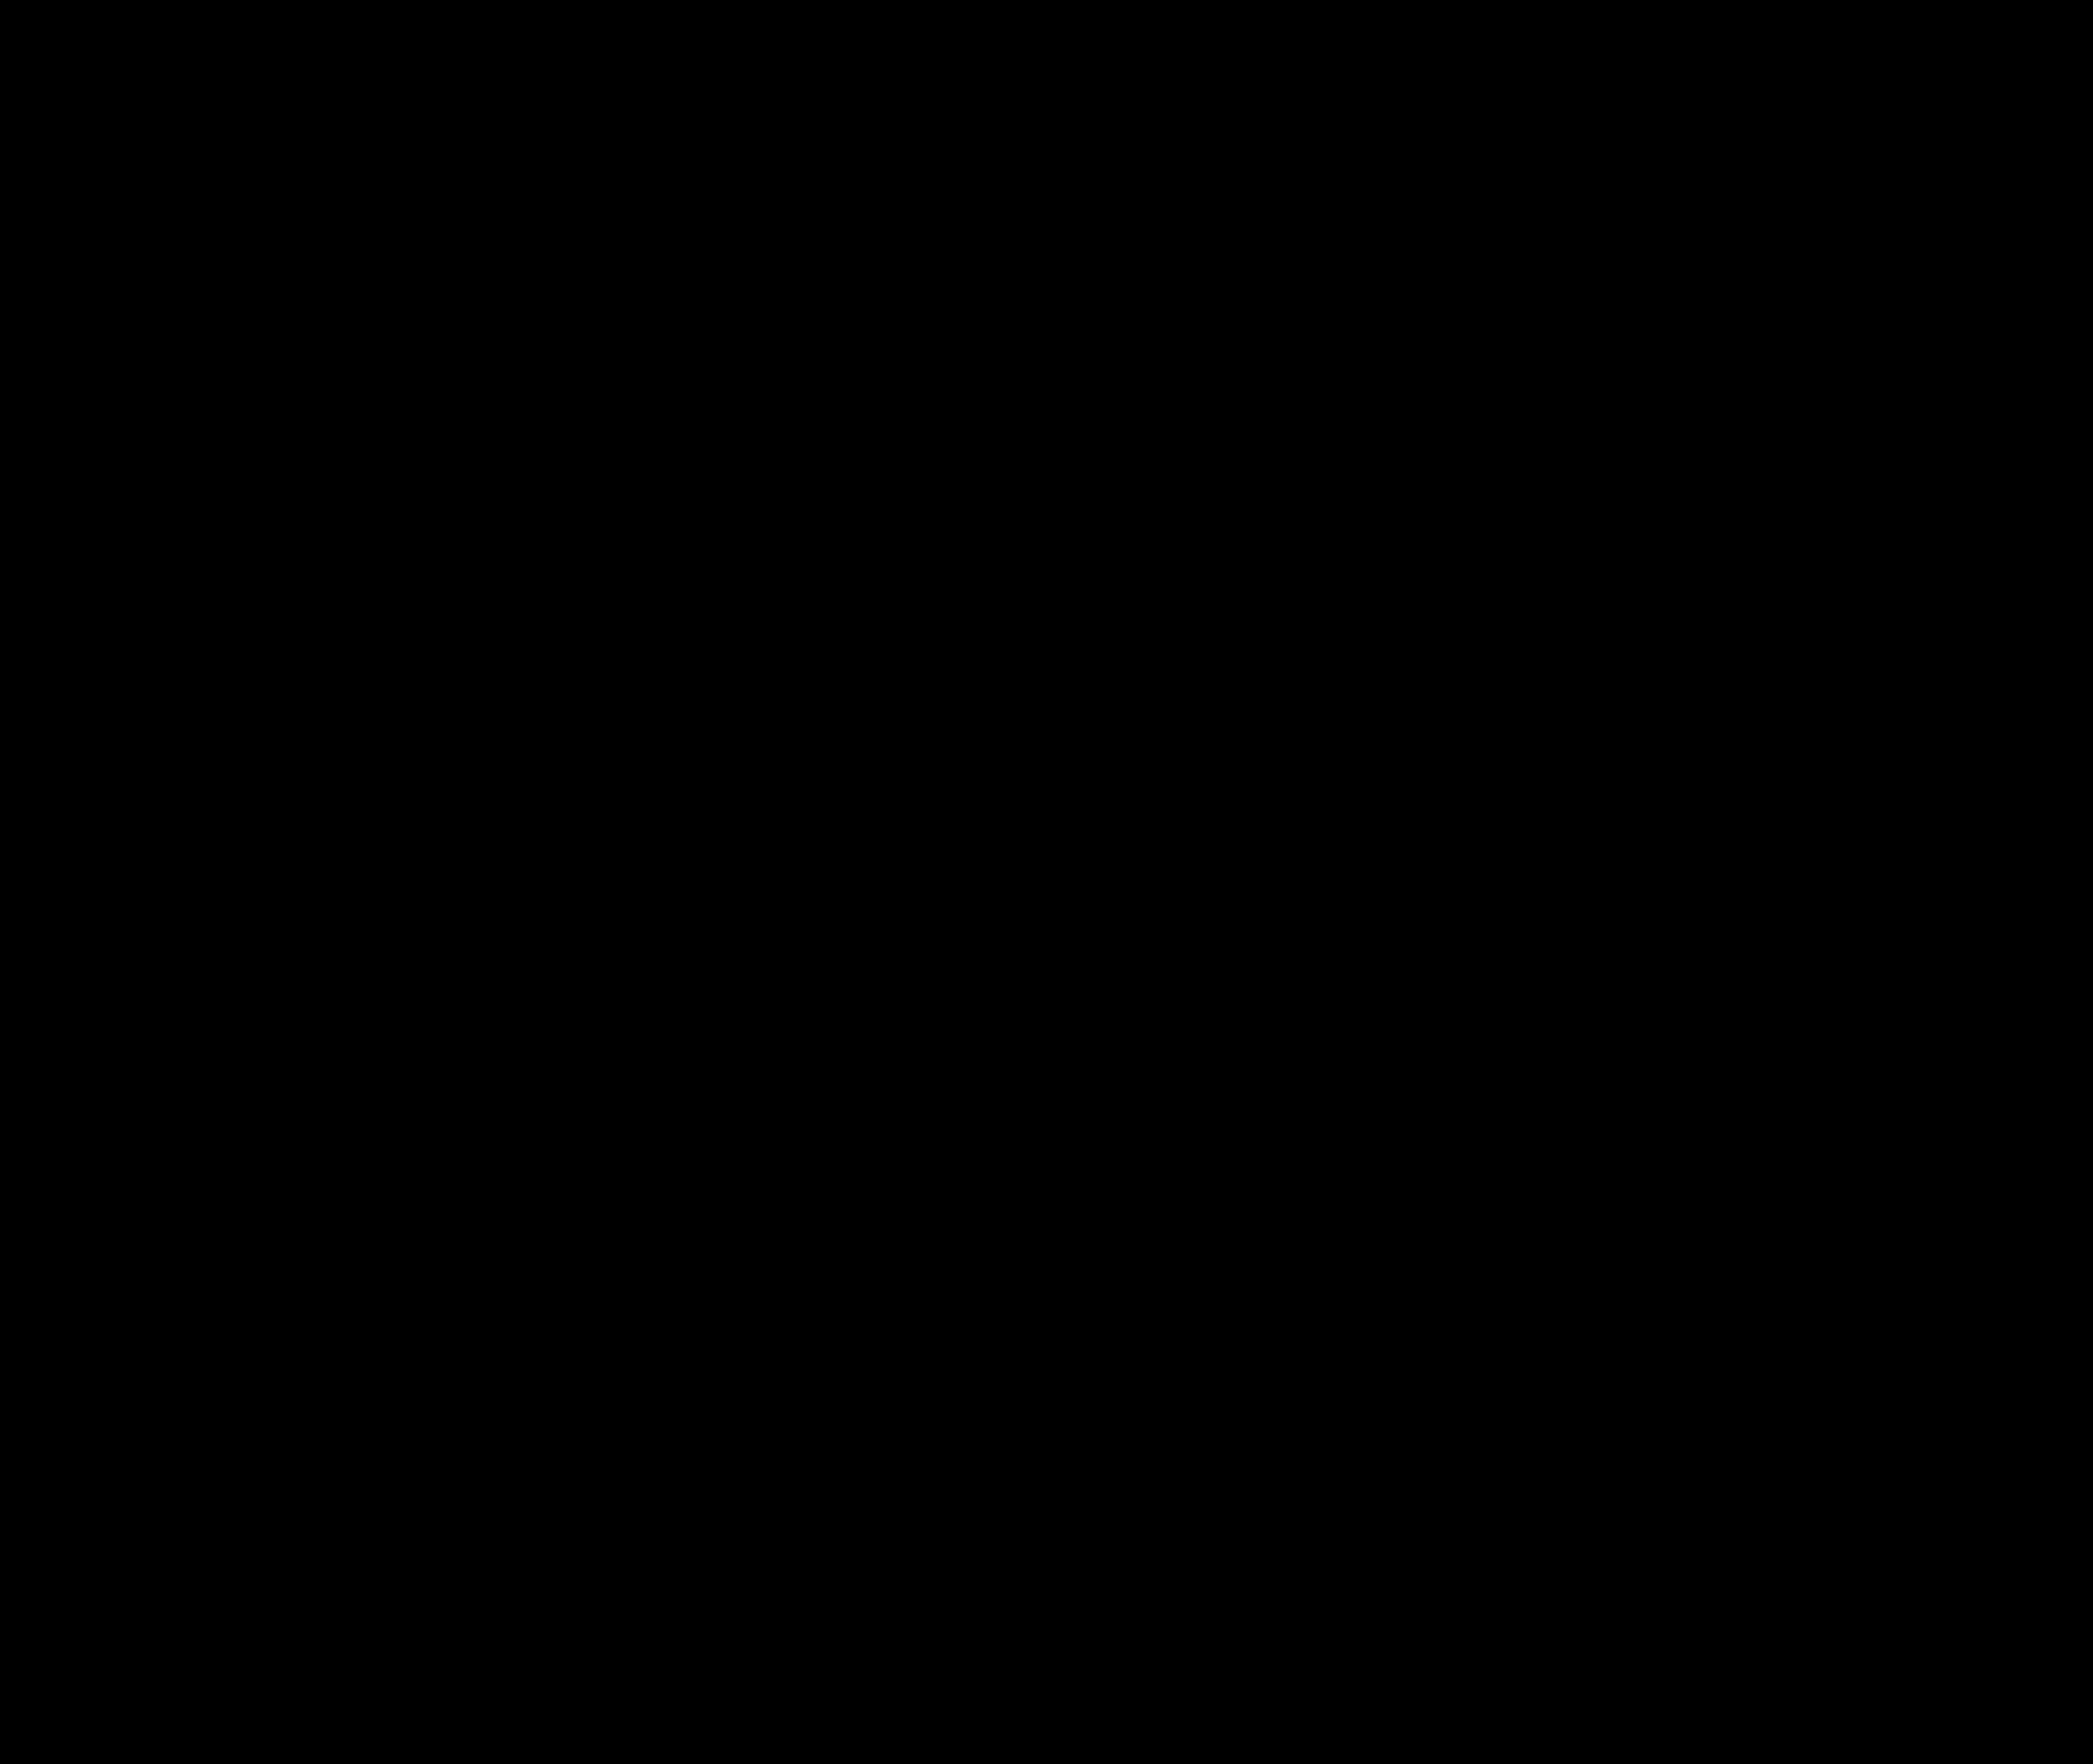
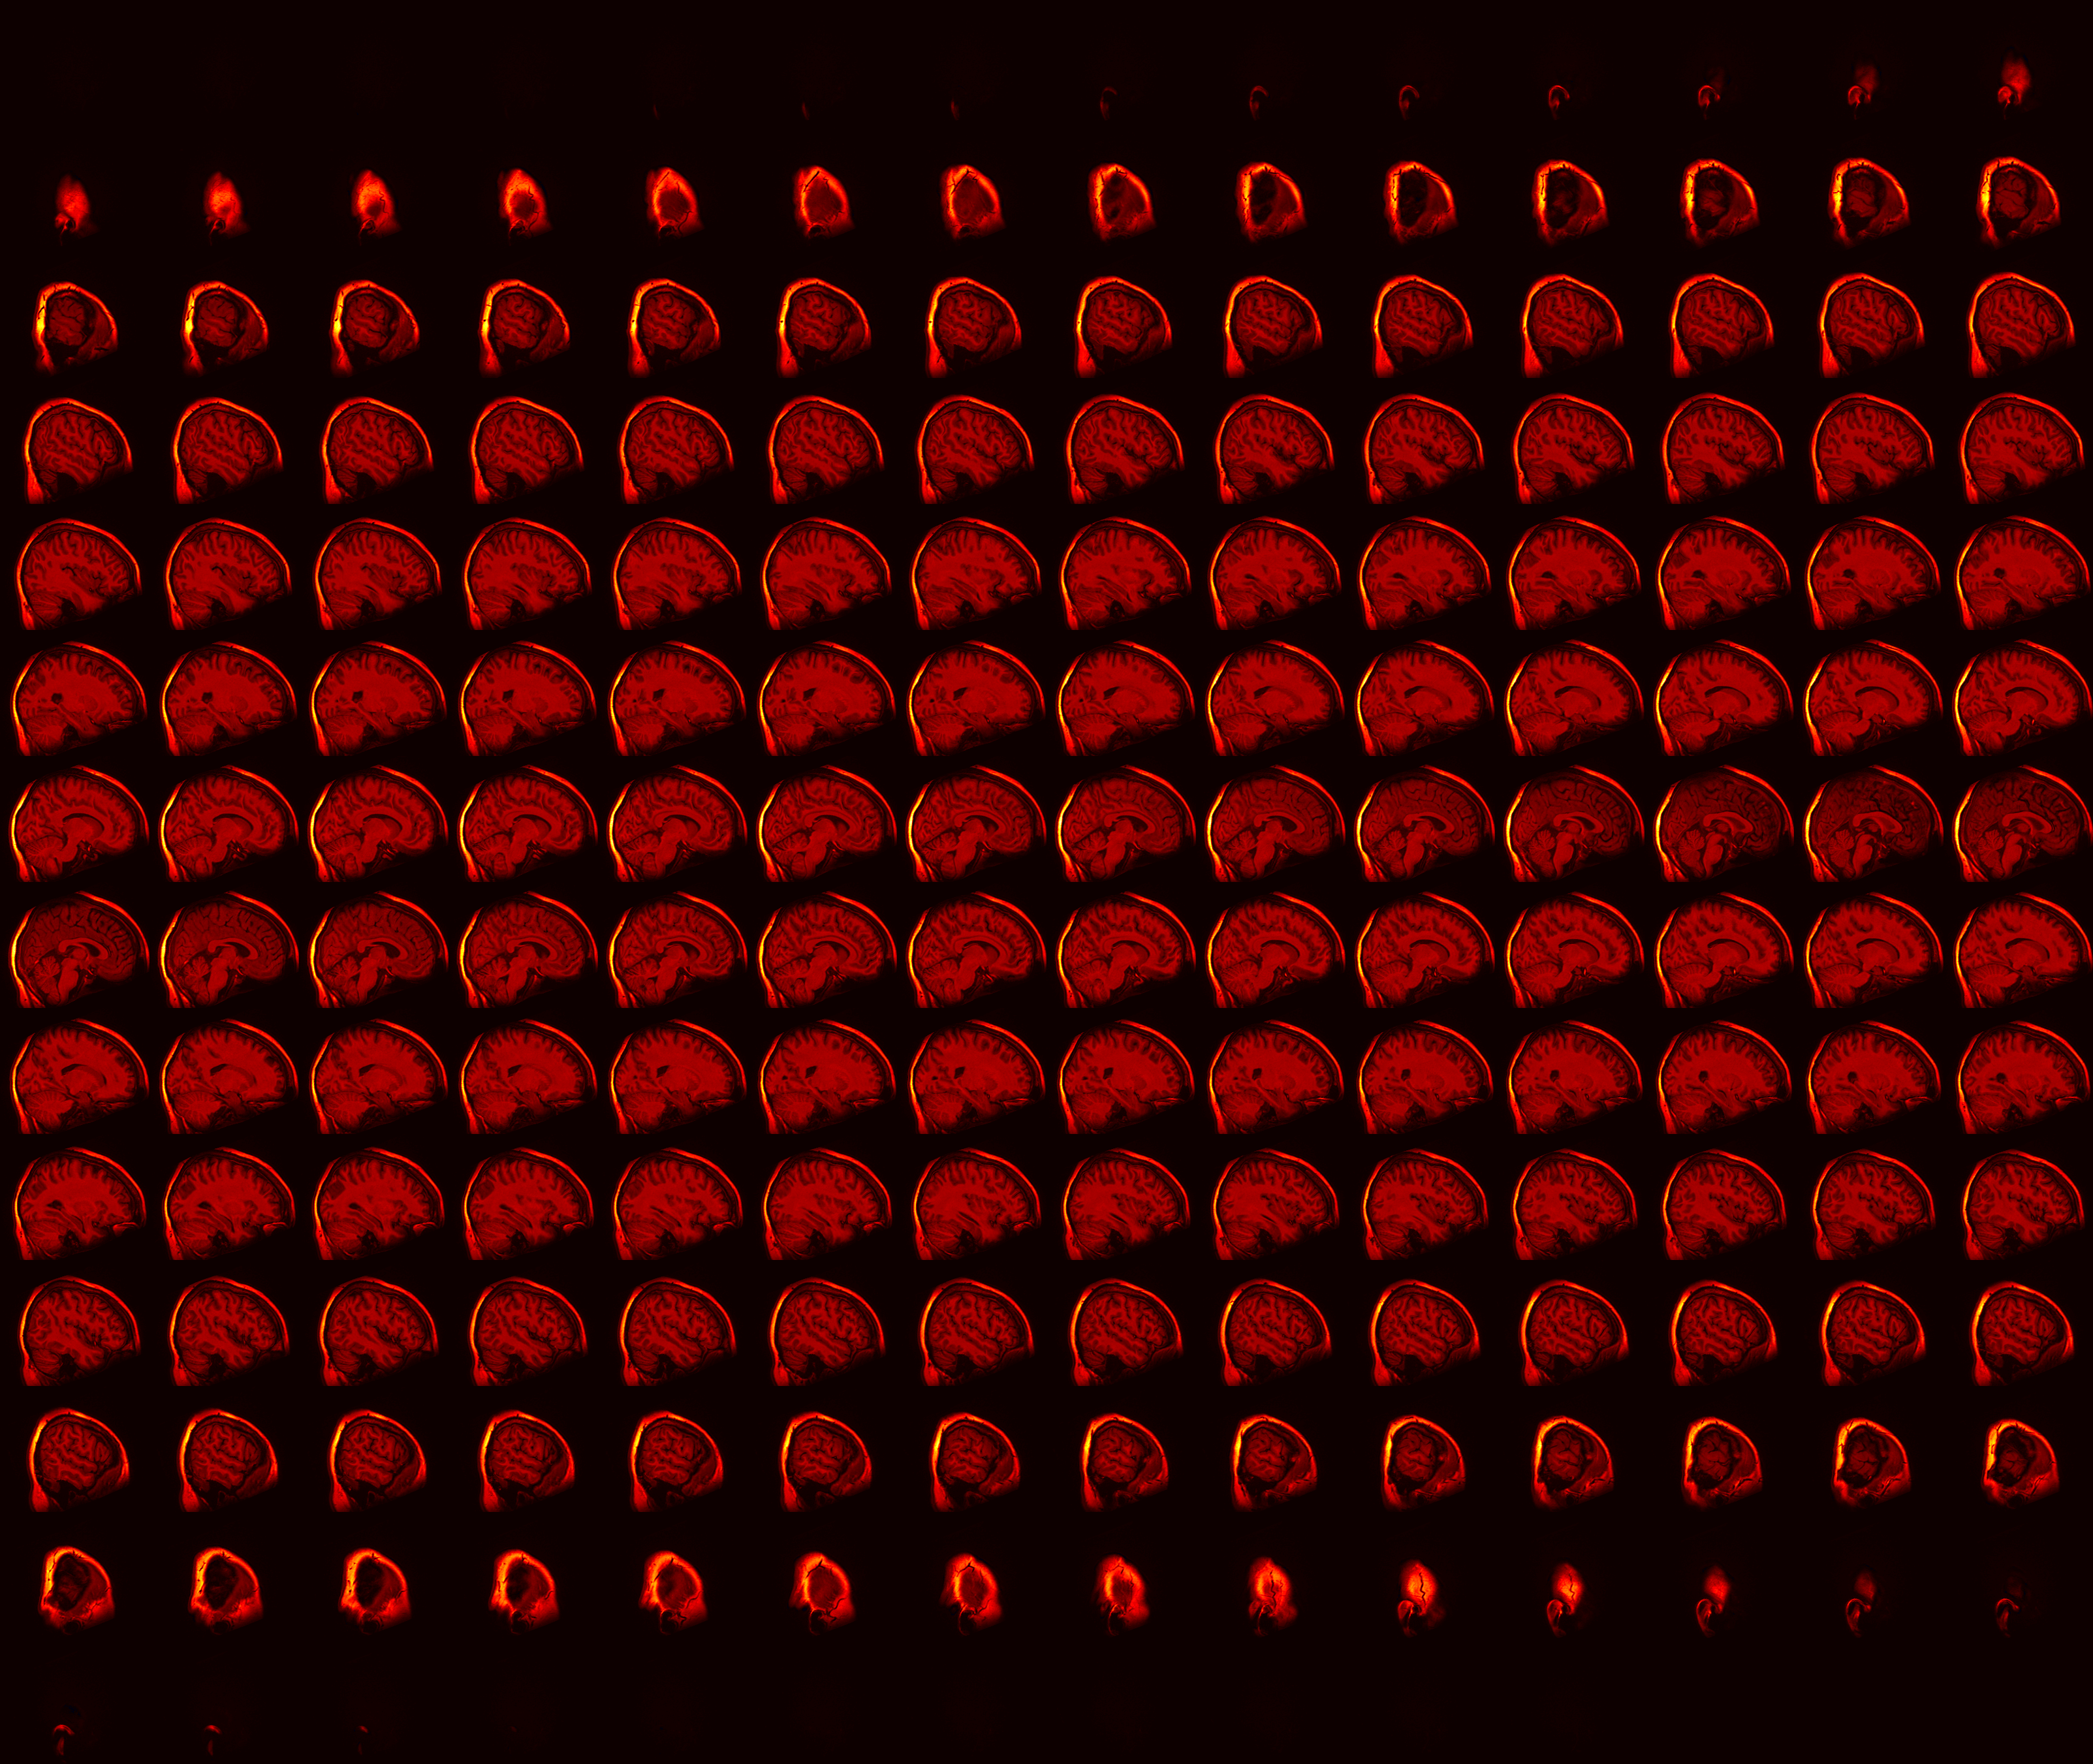

In [8]:
subj_anat_path = 'sub-Spieg16034/anat/sub-Spieg16034_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
# plotting.plot_img(subj_anat_path)
# plotting.plot_glass_brain(subj_anat_path)   
plotting.view_img(subj_anat_path, bg_img=False, #cmap=plt.get_cmap('gray'), 
                  threshold=None)

In [2]:
subj_func_path = 'sub-Spieg16034/func/'
run1_file = subj_func_path + 'sub-Spieg16034_task-ER_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

print(image.load_img(run1_file).shape)
plotting.view_img(mean_img(run1_file), 
                  bg_img=None,
                  threshold=None)

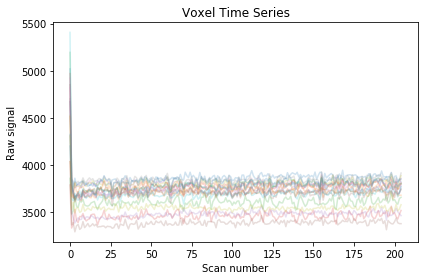

In [90]:
mask_amy = 'ROIs/bilateral_Amygdala_mask.nii.gz'

masker_amy = NiftiMasker(mask_img=mask_amy, standardize=False, detrend=False)
fmri_run1_amy_masked = masker_amy.fit_transform(run1_file)
print(fmri_run1_amy_masked.shape)

# plotting.plot_roi(mask_amy)

plt.plot(fmri_run1_amy_masked[:, :20], alpha = .2)
# plt.plot(fmri_run1_amy_masked.mean(axis=1)[1:])

plt.title('Voxel Time Series')
plt.xlabel('Scan number')
plt.ylabel('Raw signal')
plt.tight_layout()

In [42]:
n_volumes = fmri_run1_amy_masked.shape[0]
n_events = df_run1_events.shape[0]

trial_type = ['no_event']*n_volumes
trial_time = ['']*n_volumes
trial_idx = ['']*n_volumes
for i in range(n_volumes):
    for j in range(n_events):
        if i>df_run1_events['min_volume'][j] and i<df_run1_events['max_volume'][j]:
            trial_type[i] = df_run1_events['trial_type'][j]
            trial_time[i] = (i - df_run1_events['min_volume'][j])*2
            trial_idx[i] = j
            
df_run_info = pd.DataFrame({'type': trial_type,'trial': trial_idx, 'time': trial_time})
df_run_info

type trial   time
0          no_event             
1          no_event             
2          no_event             
3    negative-react     0  1.902
4    negative-react     0  3.902
..              ...   ...    ...
200        no_event             
201        no_event             
202        no_event             
203        no_event             
204        no_event             

[205 rows x 3 columns]

In [45]:
# read nifti data of 1 run
def read_and_convert_fmri_run_data(subject, mask, run_num, trial_start_time = 2, trial_end_time = 14):
    print('run', run_num, '...')
    subj_func_path = 'sub-Spieg'+ str(subject) + '/func/'
    run_file = subj_func_path + 'sub-Spieg' + str(subject) + '_task-ER_run-' + \
        str(run_num) + '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    
    # masker
    mask_file = 'ROIs/' + mask +'_mask.nii.gz'
    masker = NiftiMasker(mask_img=mask_file, standardize=False, detrend=False)
    fmri_run_masked = masker.fit_transform(run_file)    
    n_volumes = fmri_run_masked.shape[0]
    
    run_events = subj_func_path + 'run' + str(run_num)+ '_picture.csv'
    df_run_events = pd.read_csv(run_events)
    n_events = df_run_events.shape[0]
    df_run_events['trial_type'] = df_run_events['condition'].replace({'wat_ntr':'neutral', 
                                                                      'wat_IAPS_neg':'negative-react',  
                                                                      'wat_BC_neg':'negative-react', 
                                                                      'reap_IAPS_neg':'negative-regulate', 
                                                                      'reap_BC_neg':'negative-regulate'})
    # per trial: data from t = 2 to 16
    df_run_events['min_volume'] = (df_run_events['picture_time'] )/2
    df_run_events['max_volume'] = (df_run_events['picture_time'] + 16)/2    
    
    
#     # label data for each volume
#     trial_type = ['no_event']*n_volumes
#     trial_time = ['']*n_volumes
#     trial_idx = ['']*n_volumes
#     for i in range(n_volumes):
#         for j in range(n_events):
#             if i>df_run_events['min_volume'][j] and i<df_run_events['max_volume'][j]:
#                 trial_type[i] = df_run_events['trial_type'][j]
#                 trial_time[i] = (i - df_run_events['min_volume'][j])*2
#                 trial_idx[i] = j
#     df_run_info = pd.DataFrame({'type': trial_type,'trial': trial_idx, 'time': trial_time})
    
    
    run_trial_level = []
    for j in range(n_events):
        min_volume = df_run_events['min_volume'][j] + trial_start_time/2
        max_volume = df_run_events['min_volume'][j] + trial_end_time/2
        min_volume = int(np.ceil(min_volume))
        max_volume = int(np.ceil(max_volume))
#         print('event', j, 'volume:', min_volume, '-', max_volume)

        data_this_trial = fmri_run_masked[min_volume:max_volume].mean(axis = 0)
        run_trial_level.append(data_this_trial)

    run_trial_level = np.array(run_trial_level)
    # standardize data across voxels
    run_trial_level = stats.zscore(run_trial_level, axis = 0)
    
    results = {'data': run_trial_level, 'label': np.array(df_run_events['trial_type'])}
    
    return results


# read nifti data of multiple runs of 1 subject
def read_and_convert_fmri_subject_data(subject, mask, runs = 'all', trial_start_time = 2, trial_end_time = 14):
    
    import glob
    
    print("processing", subject)
    if runs == 'all':
        subj_func_path = 'sub-Spieg'+ str(subject) + '/func/'
        max_run = len(glob.glob(subj_func_path + 'run[0-9]_picture.csv'))
        runs = list(range(1, max_run + 1))
#         print(runs)
    
    subject_results =  {'data':[], 'label':[], 'run':[]}
    first_run = True
    for run in runs:
        run_results = read_and_convert_fmri_run_data(subject, mask, run, trial_start_time, trial_end_time)
        subject_results['data'].append(run_results['data'])
        subject_results['label'].extend(run_results['label'])
        subject_results['run'].extend([run] * (np.shape(run_results['data'])[0]))
#         print(np.shape(subject_results['data']))
    
    subject_results['data'] = np.array(subject_results['data'])
    # convert data from 3D to 2D array ((5, 23, 494) to (115, 494))
    subject_results['data'] = subject_results['data'].reshape((-1, subject_results['data'].shape[2]))
    print('data shape:', np.shape(subject_results['data']))
    return subject_results

In [46]:
data_sub_16034 = read_and_convert_fmri_subject_data(16034, mask = 'bilateral_Amygdala')

print(np.shape(data_sub_16034['label']))
print(data_sub_16034['run'])

processing 16034
run 1 ...
run 2 ...
run 3 ...
run 4 ...
run 5 ...
data shape: (115, 494)


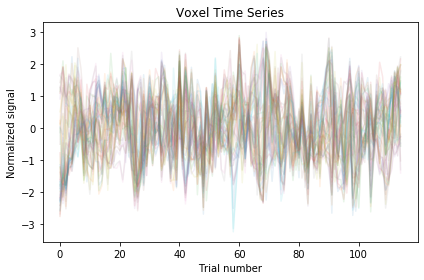

In [48]:
plt.plot(data_sub_16034['data'][:, :50], alpha = .1)

plt.title('Voxel Time Series')
plt.xlabel('Trial number')
plt.ylabel('Normalized signal')
plt.tight_layout()